In [1]:
import spacy
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import re
from textblob import TextBlob  
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load spaCy model (download with: python -m spacy download en_core_web_sm)
try:
    nlp = spacy.load("en_core_web_sm")
    print("✓ spaCy English model loaded successfully")
except OSError:
    print("Please install spaCy English model: python -m spacy download en_core_web_sm")
    exit()

✓ spaCy English model loaded successfully


In [21]:

        
class AmazonReviewsNLP:
    def __init__(self):
        self.nlp = nlp
        self.reviews_data = []
        self.processed_results = []

    def load_data(self, file_path=None, sample_size=1000):
        """
        Load Amazon reviews data. If no file provided, create sample data.
        Expected format for real data: __label__1 review_text or __label__2 review_text
        """
        if file_path:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()[:sample_size]
                
                for line in lines:
                    line = line.strip()
                    if line.startswith('__label__'):
                        parts = line.split(' ', 1)
                        if len(parts) == 2:
                            label = parts[0].replace('__label__', '')
                            text = parts[1]
                            self.reviews_data.append({
                                'label': int(label),
                                'text': text,
                                'sentiment': 'positive' if int(label) == 2 else 'negative'
                            })
                print(f"✓ Loaded {len(self.reviews_data)} reviews from file")
            except FileNotFoundError:
                print(f"File {file_path} not found. Creating sample data instead.")
                self.create_sample_data()
        else:
            self.create_sample_data()

    def create_sample_data(self):
        """Create sample Amazon review data for demonstration"""
        sample_reviews = [
            {
                'label': 2,
                'text': "I absolutely love my new iPhone 15 Pro from Apple! The camera quality is amazing and the battery life is fantastic. Best purchase ever!",
                'sentiment': 'positive'
            },
            {
                'label': 1,
                'text': "The Samsung Galaxy phone I ordered was defective. Poor build quality and the screen cracked after one day. Very disappointed with Amazon's service.",
                'sentiment': 'negative'
            },
            {
                'label': 2,
                'text': "Sony WH-1000XM4 headphones are incredible! The noise cancellation works perfectly and the sound quality from Sony is top-notch.",
                'sentiment': 'positive'
            },
            {
                'label': 1, 
                'text': "Nike Air Max shoes were uncomfortable and overpriced. The Adidas version was much better. Would not recommend this Nike product.",
                'sentiment': 'negative'
            },
            {
                'label': 2,
                'text': "The MacBook Pro from Apple exceeded my expectations. Fast processor and great display. Perfect for work and entertainment!",
                'sentiment': 'positive'
            },
            {
                'label': 1,
                'text': "Dell laptop arrived damaged. Customer service was unhelpful and the product quality was poor. Waste of money.",
                'sentiment': 'negative'
            },
            {
                'label': 2,
                'text': "Amazon Echo Dot with Alexa is so convenient! The voice recognition is accurate and it integrates well with my smart home devices.",
                'sentiment': 'positive'
            },
            {
                'label': 1,
                'text': "The Kindle Fire tablet from Amazon was slow and buggy. Battery died quickly and apps crashed frequently.",
                'sentiment': 'negative'
            },
            {
                'label': 2,
                'text': "Love my new Canon EOS camera! The image quality is professional-grade and the autofocus is lightning fast.",
                'sentiment': 'positive'
            },
            {
                'label': 1,
                'text': "Microsoft Surface Pro was overheating constantly. Poor thermal design and customer support was terrible.",
                'sentiment': 'negative'
            }
        ]
        
        self.reviews_data = sample_reviews
        print(f"✓ Created {len(self.reviews_data)} sample reviews for demonstration")

    def process_reviews(self):
        """Process all reviews for NER and sentiment analysis"""
        print("Processing reviews...")
        
        for i, review in enumerate(self.reviews_data):
            text = review['text']
            
            # Extract entities
            entities = self.extract_entities(text)
            
            # Analyze sentiment
            sentiment_analysis = self.analyze_sentiment_rule_based(text)
            
            # Store results
            result = {
                'review_id': i,
                'original_text': text,
                'original_label': review['label'],
                'original_sentiment': review['sentiment'],
                'extracted_entities': entities,
                'sentiment_analysis': sentiment_analysis,
                'products_found': entities['products'],
                'brands_found': entities['brands']
            }
            
            self.processed_results.append(result)
        
        print(f"✓ Processed {len(self.processed_results)} reviews")

    def extract_entities(self, text):
        """Extract named entities using spaCy NER"""
        doc = self.nlp(text)
        entities = {
            'products': [],
            'brands': [],
            'organizations': [],
            'money': [],
            'all_entities': []
        }
        
        # Common product/brand keywords to help identify entities
        product_keywords = ['iphone', 'galaxy', 'macbook', 'kindle', 'echo', 'surface', 'airpods', 'xbox', 'playstation']
        brand_keywords = ['apple', 'samsung', 'sony', 'nike', 'adidas', 'dell', 'microsoft', 'amazon', 'google', 'canon']
        
        for ent in doc.ents:
            entity_info = {
                'text': ent.text,
                'label': ent.label_,
                'description': spacy.explain(ent.label_)
            }
            entities['all_entities'].append(entity_info)
            
            # Classify entities
            if ent.label_ in ['PRODUCT', 'WORK_OF_ART'] or any(keyword in ent.text.lower() for keyword in product_keywords):
                entities['products'].append(ent.text)
            elif ent.label_ in ['ORG', 'PERSON'] or any(keyword in ent.text.lower() for keyword in brand_keywords):
                entities['brands'].append(ent.text)
            elif ent.label_ == 'ORG':
                entities['organizations'].append(ent.text)
            elif ent.label_ == 'MONEY':
                entities['money'].append(ent.text)
        
        # Additional pattern matching for products and brands
        text_lower = text.lower()
        for keyword in product_keywords:
            if keyword in text_lower and keyword.title() not in entities['products']:
                entities['products'].append(keyword.title())
        
        for keyword in brand_keywords:
            if keyword in text_lower and keyword.title() not in entities['brands']:
                entities['brands'].append(keyword.title())
        
        return entities
    def analyze_sentiment_rule_based(self, text):
        """Rule-based sentiment analysis"""
        # Positive and negative word lists
        positive_words = [
            'love', 'amazing', 'fantastic', 'excellent', 'great', 'perfect', 'wonderful',
            'awesome', 'brilliant', 'outstanding', 'superb', 'incredible', 'best',
            'good', 'nice', 'beautiful', 'impressive', 'satisfied', 'happy', 'pleased'
        ]
        
        negative_words = [
            'hate', 'terrible', 'awful', 'horrible', 'bad', 'worst', 'disappointing',
            'poor', 'defective', 'broken', 'useless', 'waste', 'overpriced', 'slow',
            'buggy', 'crashed', 'damaged', 'unhelpful', 'uncomfortable', 'disappointed'
        ]
        
        # Intensifiers
        intensifiers = ['very', 'extremely', 'really', 'absolutely', 'completely', 'totally']
        
        text_lower = text.lower()
        words = text_lower.split()
        
        positive_score = 0
        negative_score = 0
        
        for i, word in enumerate(words):
            # Check for intensifiers
            multiplier = 1
            if i > 0 and words[i-1] in intensifiers:
                multiplier = 2
            
            if word in positive_words:
                positive_score += (1 * multiplier)
            elif word in negative_words:
                negative_score += (1 * multiplier)
        
        # Handle negations (simple approach)
        negation_words = ['not', 'no', 'never', 'nothing', 'nobody', 'nowhere', "don't", "doesn't", "didn't", "won't", "wouldn't", "can't", "couldn't"]
        for neg_word in negation_words:
            if neg_word in text_lower:
                # Flip scores if negation is present
                positive_score, negative_score = negative_score * 0.5, positive_score * 0.5
                break
        
        # Determine overall sentiment
        if positive_score > negative_score:
            sentiment = 'positive'
            confidence = positive_score / (positive_score + negative_score + 1)
        elif negative_score > positive_score:
            sentiment = 'negative'
            confidence = negative_score / (positive_score + negative_score + 1)
        else:
            sentiment = 'neutral'
            confidence = 0.5
        
        return {
            'sentiment': sentiment,
            'confidence': confidence,
            'positive_score': positive_score,
            'negative_score': negative_score
        }
    def display_results(self):
        """Display analysis results"""
        print("\n" + "="*80)
        print("AMAZON REVIEWS NLP ANALYSIS RESULTS")
        print("="*80)
        
        # Summary statistics
        total_reviews = len(self.processed_results)
        correct_predictions = sum(1 for r in self.processed_results 
                                if r['sentiment_analysis']['sentiment'] == r['original_sentiment'])
        accuracy = correct_predictions / total_reviews * 100
        
        print(f"\nSUMMARY STATISTICS:")
        print(f"Total Reviews Processed: {total_reviews}")
        print(f"Sentiment Analysis Accuracy: {accuracy:.1f}%")
        all_products = []
        all_brands = []
        for result in self.processed_results:
            all_products.extend(result['products_found'])
            all_brands.extend(result['brands_found'])
        
        product_counts = Counter(all_products)
        brand_counts = Counter(all_brands)
        
        print(f"\nENTITY EXTRACTION SUMMARY:")
        print(f"Unique Products Found: {len(set(all_products))}")
        print(f"Unique Brands Found: {len(set(all_brands))}")
        print(f"Most Common Products: {dict(product_counts.most_common(5))}")
        print(f"Most Common Brands: {dict(brand_counts.most_common(5))}")
        
        # Detailed results for each review
        print(f"\nDETAILED ANALYSIS:")
        print("-" * 80)
        
        for i, result in enumerate(self.processed_results):
            print(f"\nReview #{i+1}:")
            print(f"Text: {result['original_text'][:100]}{'...' if len(result['original_text']) > 100 else ''}")
            print(f"Original Sentiment: {result['original_sentiment']}")
            print(f"Predicted Sentiment: {result['sentiment_analysis']['sentiment']} (confidence: {result['sentiment_analysis']['confidence']:.3f})")
            print(f"Products Found: {result['products_found']}")
            print(f"Brands Found: {result['brands_found']}")
            
            # Show all entities found
            if result['extracted_entities']['all_entities']:
                print("All Named Entities:")
                for entity in result['extracted_entities']['all_entities']:
                    print(f"  • {entity['text']} ({entity['label']}: {entity['description']})")
            
            print("-" * 40)

    def create_visualizations(self):
        """Create visualizations of the analysis results"""
        # Sentiment distribution
        sentiments = [r['sentiment_analysis']['sentiment'] for r in self.processed_results]
        sentiment_counts = Counter(sentiments)
        
        # Product and brand frequency
        all_products = []
        all_brands = []
        for result in self.processed_results:
            all_products.extend(result['products_found'])
            all_brands.extend(result['brands_found'])
        
        product_counts = Counter(all_products)
        brand_counts = Counter(all_brands)
        
        # Create plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Sentiment distribution
        ax1.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%')
        ax1.set_title('Sentiment Distribution')
          
        # Accuracy comparison
        original_sentiments = [r['original_sentiment'] for r in self.processed_results]
        predicted_sentiments = [r['sentiment_analysis']['sentiment'] for r in self.processed_results]
        accuracy_data = {'Original': Counter(original_sentiments), 'Predicted': Counter(predicted_sentiments)}
        
        x = np.arange(len(set(original_sentiments)))
        width = 0.35
        ax2.bar(x - width/2, [accuracy_data['Original']['positive'], accuracy_data['Original']['negative']], 
                width, label='Original', alpha=0.7)
        ax2.bar(x + width/2, [accuracy_data['Predicted'].get('positive', 0), accuracy_data['Predicted'].get('negative', 0)], 
                width, label='Predicted', alpha=0.7)
        ax2.set_xlabel('Sentiment')
        ax2.set_ylabel('Count')
        ax2.set_title('Original vs Predicted Sentiment')
        ax2.set_xticks(x)
        ax2.set_xticklabels(['Positive', 'Negative'])
        ax2.legend()
        
        # Top products
        if product_counts:
            top_products = dict(product_counts.most_common(5))
            ax3.barh(list(top_products.keys()), list(top_products.values()))
            ax3.set_title('Most Mentioned Products')
            ax3.set_xlabel('Frequency')
        
        # Top brands
        if brand_counts:
            top_brands = dict(brand_counts.most_common(5))
            ax4.barh(list(top_brands.keys()), list(top_brands.values()))
            ax4.set_title('Most Mentioned Brands')
            ax4.set_xlabel('Frequency')
        
        plt.tight_layout()
        plt.show()

Amazon Reviews NLP Analysis with spaCy
✓ Created 10 sample reviews for demonstration
Processing reviews...
✓ Processed 10 reviews

AMAZON REVIEWS NLP ANALYSIS RESULTS

SUMMARY STATISTICS:
Total Reviews Processed: 10
Sentiment Analysis Accuracy: 60.0%

ENTITY EXTRACTION SUMMARY:
Unique Products Found: 9
Unique Brands Found: 13
Most Common Products: {'Iphone': 1, 'Galaxy': 1, 'The MacBook Pro': 1, 'Macbook': 1, 'Echo Dot': 1}
Most Common Brands: {'Amazon': 3, 'Apple': 2, 'Samsung': 1, 'Sony WH-1000XM4': 1, 'Sony': 1}

DETAILED ANALYSIS:
--------------------------------------------------------------------------------

Review #1:
Text: I absolutely love my new iPhone 15 Pro from Apple! The camera quality is amazing and the battery lif...
Original Sentiment: positive
Predicted Sentiment: positive (confidence: 0.800)
Products Found: ['Iphone']
Brands Found: ['Apple']
All Named Entities:
  • 15 (CARDINAL: Numerals that do not fall under another type)
  • Apple (ORG: Companies, agencies, insti

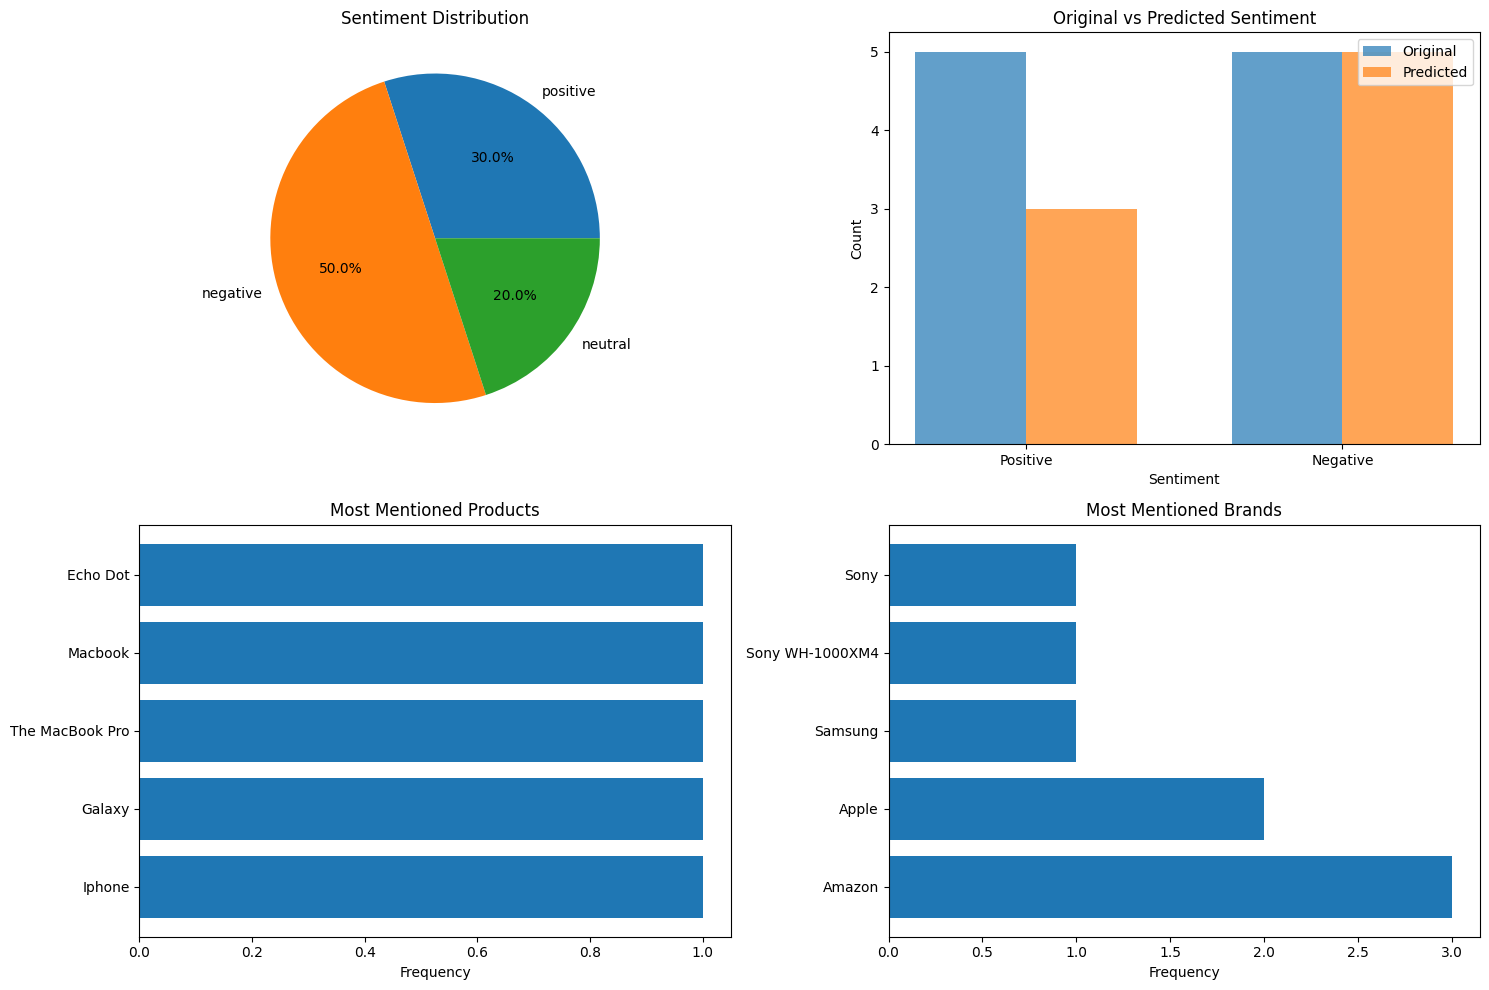

In [27]:
# Main execution
def main():
    print("Amazon Reviews NLP Analysis with spaCy")
    print("=" * 50)
    
    # Initialize analyzer
    analyzer = AmazonReviewsNLP()
    
    # Load data (replace with actual file path if available)
    # analyzer.load_data('path/to/amazon_reviews.txt', sample_size=1000)
    analyzer.load_data()  # Uses sample data
    
    # Process reviews
    analyzer.process_reviews()
    
    # Display results
    analyzer.display_results()
    
    # Create visualizations
    try:
        analyzer.create_visualizations()
    except Exception as e:
        print(f"Visualization error: {e}")
        print("Make sure matplotlib is installed: pip install matplotlib seaborn")

if __name__ == "__main__":
    main()

# Additional utility functions for extended analysis
def analyze_entity_sentiment_correlation(analyzer):
    """Analyze correlation between specific entities and sentiment"""
    entity_sentiment = defaultdict(list)
    
    for result in analyzer.processed_results:
        sentiment = result['sentiment_analysis']['sentiment']
        for product in result['products_found']:
            entity_sentiment[product].append(sentiment)
        for brand in result['brands_found']:
            entity_sentiment[brand].append(sentiment)
    
    print("\nENTITY-SENTIMENT CORRELATION:")
    print("-" * 40)
    for entity, sentiments in entity_sentiment.items():
        if len(sentiments) > 1:  # Only show entities with multiple mentions
            positive_ratio = sentiments.count('positive') / len(sentiments)
            print(f"{entity}: {positive_ratio:.2f} positive ratio ({len(sentiments)} mentions)")


In [29]:
def export_results_to_csv(analyzer, filename='amazon_reviews_analysis.csv'):
    """Export analysis results to CSV"""
    data = []
    for result in analyzer.processed_results:
        data.append({
            'review_id': result['review_id'],
            'original_text': result['original_text'],
            'original_sentiment': result['original_sentiment'],
            'predicted_sentiment': result['sentiment_analysis']['sentiment'],
            'confidence': result['sentiment_analysis']['confidence'],
            'products_found': ', '.join(result['products_found']),
            'brands_found': ', '.join(result['brands_found']),
            'total_entities': len(result['extracted_entities']['all_entities'])
        })
    
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"✓ Results exported to {filename}")


In [32]:
analyzer = AmazonReviewsNLP()
analyzer.load_data()
analyzer.process_reviews()

✓ Created 10 sample reviews for demonstration
Processing reviews...
✓ Processed 10 reviews


In [33]:
export_results_to_csv(analyzer, 'my_results.csv')

✓ Results exported to my_results.csv
